In [75]:
from transformers import pipeline
from nltk import sent_tokenize
import nltk
import torch
from glob import glob
import pandas as pd
import numpy as np

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\slywi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Load model

In [5]:
model_name = 'facebook/bart-large-mnli'
device = 0 if torch.cuda.is_available() else 'cpu'

In [7]:
def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

In [8]:
theme_classifier = load_model(device)

c:\Users\slywi\anaconda3\envs\tf_gpu\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\slywi\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\slywi\anaconda3\envs\tf_gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: Fu

In [15]:
theme_list = [ "love", "romance", "comedy", "drama",
    "business", "office", "friendship",
    "family", "fake dating", "jealousy",
    "secret relationship", "CEO", "marriage",
    "humor", "betrayal", "conflict", "dating", "romantic comedy"]

In [17]:
theme_classifier(
    "I love you",
    theme_list,
    multi_label=True
)

{'sequence': 'I love you',
 'labels': ['love',
  'family',
  'romance',
  'friendship',
  'marriage',
  'romantic comedy',
  'office',
  'dating',
  'CEO',
  'secret relationship',
  'conflict',
  'drama',
  'humor',
  'comedy',
  'fake dating',
  'jealousy',
  'betrayal',
  'business'],
 'scores': [0.9899700284004211,
  0.9899320006370544,
  0.9605304002761841,
  0.9256911277770996,
  0.45934462547302246,
  0.33738037943840027,
  0.2959821820259094,
  0.24753901362419128,
  0.23426198959350586,
  0.22936999797821045,
  0.11664266884326935,
  0.06687180697917938,
  0.06453361362218857,
  0.050936367362737656,
  0.014546990394592285,
  0.003691155230626464,
  0.0015365141443908215,
  0.0003656400949694216]}

## Load dataset

In [23]:
files = glob('../dataset/Subtitles/*.ass')

In [24]:
files[0]

'../dataset/Subtitles\\business_proposal_very_long_ep01.ass'

In [26]:
with open(files[0],'r') as file:
    lines = file.readlines()
    lines = lines[15:]
    lines = [",".join(line.split(',')[9:]) for line in lines]

In [28]:
lines[:5]

['I think I’ve made a huge mistake.\n',
 'I need time to think.\n',
 'You’re fired... Just kidding.\n',
 'You’re acting really strange today.\n',
 'Are you serious about her?\n']

In [29]:
" ".join(lines[:10])

"I think I’ve made a huge mistake.\n I need time to think.\n You’re fired... Just kidding.\n You’re acting really strange today.\n Are you serious about her?\n Grandpa will never approve of this.\n I never thought I’d say this, but I like you.\n Don’t act like you don’t care.\n You’re crossing a line, Mr. Kang.\n I'm not ready for a relationship.\n"

In [36]:
int(files[0].split('_ep')[-1].split('.')[0].strip())

1

In [42]:
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path+'/*.ass')

    scripts = []
    episode_num = []

    for path in subtitles_paths:
        #Read lines
        with open(path,'r') as file:
            lines = file.readlines()
            lines = lines[15:]
            lines = [",".join(line.split(',')[9:]) for line in lines]

        script = " ".join(lines)

        episode = int(path.split('_ep')[-1].split('.')[0].strip())

        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode": episode_num, "scripts":scripts})

    return df

In [43]:
dataset_path = "../dataset/Subtitles"
df = load_subtitles_dataset(dataset_path)

In [44]:
df.head()

,episode,scripts
0,1,I think I’ve made a huge mistake.\n I need tim...
1,2,I didn't come here to fall in love.\n If it’s ...
2,3,How long have you two been dating?\n I think I...
3,4,Don’t act like you don’t care.\n I think I’ve ...
4,5,How long have you two been dating?\n Why does ...


## Run model

In [50]:
script = df.iloc[0]['scripts']

In [51]:
script

"I think I’ve made a huge mistake.\n I need time to think.\n You’re fired... Just kidding.\n You’re acting really strange today.\n Are you serious about her?\n Grandpa will never approve of this.\n I never thought I’d say this, but I like you.\n Don’t act like you don’t care.\n You’re crossing a line, Mr. Kang.\n I'm not ready for a relationship.\n Do you think pretending will make it easier?\n You're late again, Ms. Shin.\n You deserve someone better.\n You’re crossing a line, Mr. Kang.\n Why are you crying?\n Don’t tell anyone what you saw.\n This is my final warning.\n This is just a business arrangement.\n It's just business, remember?\n You’re not who I expected to meet today.\n Stop mixing work with your emotions.\n You look nervous. First date?\n You’re crossing a line, Mr. Kang.\n What happened to our agreement?\n Why are you crying?\n Do you want to grab dinner later?\n We can't keep lying forever.\n You’re crossing a line, Mr. Kang.\n Do you want to grab dinner later?\n Let's

In [52]:
script_sentences = sent_tokenize(script)
script_sentences[:3]

['I think I’ve made a huge mistake.',
 'I need time to think.',
 'You’re fired... Just kidding.']

In [55]:
#Batch sentences
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size):
    sent = " ".join(script_sentences[index:index+sentence_batch_size])
    script_batches.append(sent)

In [56]:
script_batches[:2]

["I think I’ve made a huge mistake. I need time to think. You’re fired... Just kidding. You’re acting really strange today. Are you serious about her? Grandpa will never approve of this. I never thought I’d say this, but I like you. Don’t act like you don’t care. You’re crossing a line, Mr. Kang. I'm not ready for a relationship. Do you think pretending will make it easier? You're late again, Ms. Shin. You deserve someone better. You’re crossing a line, Mr. Kang. Why are you crying? Don’t tell anyone what you saw. This is my final warning. This is just a business arrangement. It's just business, remember? You’re not who I expected to meet today.",
 "Stop mixing work with your emotions. You look nervous. First date? You’re crossing a line, Mr. Kang. What happened to our agreement? Why are you crying? Do you want to grab dinner later? We can't keep lying forever. You’re crossing a line, Mr. Kang. Do you want to grab dinner later? Let's stop this before it gets worse. Don’t tell anyone wh

In [121]:
theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
)

In [122]:
theme_output

[{'sequence': "I think I’ve made a huge mistake. I need time to think. You’re fired... Just kidding. You’re acting really strange today. Are you serious about her? Grandpa will never approve of this. I never thought I’d say this, but I like you. Don’t act like you don’t care. You’re crossing a line, Mr. Kang. I'm not ready for a relationship. Do you think pretending will make it easier? You're late again, Ms. Shin. You deserve someone better. You’re crossing a line, Mr. Kang. Why are you crying? Don’t tell anyone what you saw. This is my final warning. This is just a business arrangement. It's just business, remember? You’re not who I expected to meet today.",
  'labels': ['business',
   'conflict',
   'drama',
   'betrayal',
   'office',
   'secret relationship',
   'fake dating',
   'humor',
   'dating',
   'CEO',
   'comedy',
   'family',
   'jealousy',
   'marriage',
   'romantic comedy',
   'friendship',
   'love',
   'romance'],
  'scores': [0.9937365651130676,
   0.9552564024925

In [123]:
# Wrangle output
themes={}
for output in theme_output:
    for label, score in zip(output['labels'], output['scores']):
        if label not in themes:
            themes[label]=[]
        themes[label].append(score)

In [124]:
themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

In [125]:
themes

{'business': 0.7965804636478424,
 'conflict': 0.9559433460235596,
 'drama': 0.7822145223617554,
 'betrayal': 0.7059825956821442,
 'office': 0.7091964781284332,
 'secret relationship': 0.787360817193985,
 'fake dating': 0.7125821113586426,
 'humor': 0.3158762827515602,
 'dating': 0.7705077528953552,
 'CEO': 0.4378570169210434,
 'comedy': 0.2567109018564224,
 'family': 0.28836193680763245,
 'jealousy': 0.17468198761343956,
 'marriage': 0.10240120254456997,
 'romantic comedy': 0.17753790691494942,
 'friendship': 0.1192261315882206,
 'love': 0.2646853611804545,
 'romance': 0.35761008807457983}

In [127]:
def get_themes_inference(script):
    script_sentences = sent_tokenize(script)

    #Batch sentences
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)

    #Run model
    theme_output = theme_classifier(
    script_batches[:2],
    theme_list,
    multi_label=True
    )

    #Wrangle ouput
    themes={}
    for output in theme_output:
        for label, score in zip(output['labels'], output['scores']):
            if label not in themes:
                themes[label]=[]
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key, value in themes.items()}

    return themes

In [128]:
df = df.head(2)
df

,episode,scripts,conflict,drama,betrayal,office,secret relationship,fake dating,humor,dating,CEO,comedy,family,jealousy,marriage,romantic comedy,friendship,love,romance,business
0,1,I think I’ve made a huge mistake.\n I need tim...,0.955943,0.782215,0.705983,0.709196,0.787361,0.712582,0.315876,0.770508,0.437857,0.256711,0.288362,0.174682,0.102401,0.177538,0.119226,0.264685,0.357610,0.79658
1,2,I didn't come here to fall in love.\n If it’s ...,0.955196,0.804672,0.930403,0.597145,0.835442,0.909900,0.085617,0.928606,0.548359,0.136540,0.487014,0.318506,0.147650,0.221600,0.050116,0.111800,0.132083,0.98531


In [129]:
output_themes = df['scripts'].apply(get_themes_inference)

In [130]:
output_themes

0    {'business': 0.7965804636478424, 'conflict': 0...
1    {'business': 0.9853103458881378, 'conflict': 0...
Name: scripts, dtype: object

In [131]:
theme_df = pd.DataFrame(output_themes.tolist())

In [132]:
theme_df

,business,conflict,drama,betrayal,office,secret relationship,fake dating,humor,dating,CEO,comedy,family,jealousy,marriage,romantic comedy,friendship,love,romance
0,0.79658,0.955943,0.782215,0.705983,0.709196,0.787361,0.712582,0.315876,0.770508,0.437857,0.256711,0.288362,0.174682,0.102401,0.177538,0.119226,0.264685,0.357610
1,0.98531,0.955196,0.804672,0.930403,0.597145,0.835442,0.909900,0.085617,0.928606,0.548359,0.136540,0.487014,0.318506,0.147650,0.221600,0.050116,0.111800,0.132083


In [133]:
df[theme_df.columns] = theme_df
df

,episode,scripts,conflict,drama,betrayal,office,secret relationship,fake dating,humor,dating,CEO,comedy,family,jealousy,marriage,romantic comedy,friendship,love,romance,business
0,1,I think I’ve made a huge mistake.\n I need tim...,0.955943,0.782215,0.705983,0.709196,0.787361,0.712582,0.315876,0.770508,0.437857,0.256711,0.288362,0.174682,0.102401,0.177538,0.119226,0.264685,0.357610,0.79658
1,2,I didn't come here to fall in love.\n If it’s ...,0.955196,0.804672,0.930403,0.597145,0.835442,0.909900,0.085617,0.928606,0.548359,0.136540,0.487014,0.318506,0.147650,0.221600,0.050116,0.111800,0.132083,0.98531


## Visualize output

In [134]:
theme_output = df.drop(['episode', 'scripts'], axis=1).sum().reset_index()
theme_output.columns =['theme', 'score']

In [135]:
theme_output

,theme,score
0,conflict,1.911139
1,drama,1.586887
2,betrayal,1.636386
3,office,1.306341
4,secret relationship,1.622802
5,fake dating,1.622482
6,humor,0.401493
7,dating,1.699114
8,CEO,0.986216
9,comedy,0.393251


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

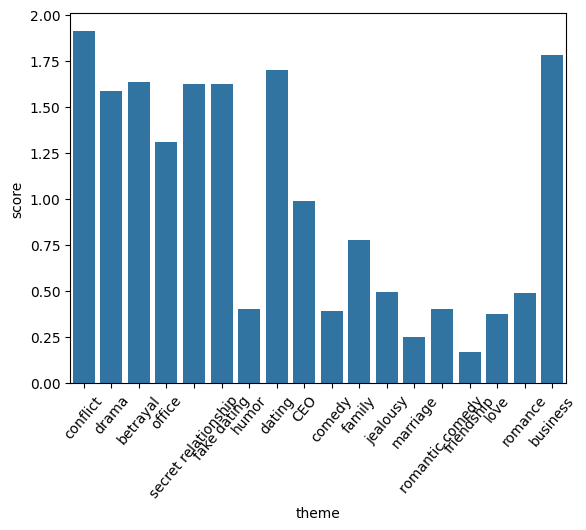

In [137]:
sns.barplot(data = theme_output, x="theme", y="score")
plt.xticks(rotation=50)
plt.show()